# PER with Sparse Pauli-Lindblad Model
In quantum simulation algorithms, the result at the end of the algorithm is usually not a single binary value, but instead the expectation value of some operator, which is approximated by averaging over many shots of the same circuit. In the presence of noisy operations, the estimator for such an expectation value is biased, which affects the quality of the result.

The purpose of this notebook is to illustrate a procedure for mitigating this bias and increasing the accuracy of the estimators of the expectation values. 

The first step is performing a tomography experiment to learn the noise model. A process called "Pauli twirling" can be used to convert the noise into a Pauli channel. 

The noise is then assumed to be generated by a master equation with quantum jump operators proportional to Pauli operators. The noise channel can then be expressed as $\Lambda(\rho) = e^{-\mathcal L (\rho)}$, where

$$
\hat{\mathcal L} = \sum_{k}\lambda_k (\hat P_k - \hat I)
$$

This master equation will be referred to as a "sparse Pauli-Lindblad," model. The word sparse indicates that only Pauli operators which have support on physically connected qubits are considered in the model. 

Once the $\lambda_k$ are learned, a partially inverted noise channel can be constructed:

$$
\hat \Lambda^{(\xi)} = \gamma^{(\xi)}\prod_{k}\omega^{(\xi)}_k \hat I+\text{sgn}(1-\xi)(1-\omega_k^{(\xi)})\hat P_k
$$
Where we have defined $\omega^{(\xi)}_k = \frac{1}{2}(1+e^{-2|\xi-1|\lambda_k})$ and
$$
\gamma^{(\xi)}
= \begin{cases}
\exp(2(1-\xi)\sum_k \lambda_k) & \xi < 1 \\
1 & \xi \geq 1
\end{cases}
$$
This channel can be implemented by sampling from it probabilistically and rescaling the results by the overhead $\gamma^{(\xi)}$. It can be shown that as $\xi \to 0$, 
$$
\hat \Lambda^{(\xi)} \to \hat \Lambda^{-1}
$$
the notation has been overloaded slightly, and $\Lambda^{-1}$ is used to indicate the inverse of $\Lambda$. In addition, as $\xi \to \infty$, we have $\Lambda^{(\xi)} \to P_{max}$, where $P_{max}(\rho) = I$ for all $\rho$. Because of this, measurements at different values of $\xi$ can be used to extrapolate to the zero-noise limit with an appropriate fit.

The scope of this notebook is to demonstrate the tools presented here for learning $\lambda_k$ on a simulated noisy backend, and then carrying out PER to approximate a relevant expectation value on a desired circuit.

In [30]:
from qiskit import QuantumCircuit, Aer, transpile
from qiskit.providers.fake_provider import FakeVigoV2
from matplotlib import pyplot as plt
import os
import sys
import numpy as np

sys.path.append(os.path.join(os.path.dirname(os.path.dirname(os.getcwd())), "pauli_lindblad_per"))
from tomography.experiment import SparsePauliTomographyExperiment as tomography

plt.style.use("ggplot")

def empty_log():
    with open('experiment.log', 'w'):
        pass

def print_log_file(file_path):
    try:
        with open(file_path, 'r') as file:
            for line in file:
                print(line, end='')
    except FileNotFoundError:
        print(f"Error: The file '{file_path}' was not found.")
    except Exception as e:
        print(f"An error occurred: {e}")
    #empty_log()

# Initialize backend and create circuit
The program requires access to a qiskit backend, using the topology of the processor to find the terms included in the sparse model. The circuit can be any circuit with the requirement that it only contain single and two-qubit gates, and the two-qubit gates must be self-adjoint Clifford gates such as CNOT or CZ gates. Lastly, the circuit should not have any trailing single-qubit gates. This requirement is an edge case that will be removed in future versions.

In [31]:
backend = FakeVigoV2()

In [32]:
qc = QuantumCircuit(2)
qc.rz(np.pi/2,0)
qc.sx(0)
qc.rz(3*np.pi/4,0)

qc.rz(np.pi/2,1)
qc.sx(1)
qc.rz(np.pi/2,1)

qc.cx(0,1)
qc.rz(np.pi/4,0)
qc.cx(0,1)
qc.rz(np.pi/4,0)
qc.cx(0,1)
qc.rz(np.pi/4,0)
qc.cx(0,1)
qc.draw()

┌─────────┐┌────┐┌──────────┐     ┌─────────┐     ┌─────────┐     »
q_0: ┤ Rz(π/2) ├┤ √X ├┤ Rz(3π/4) ├──■──┤ Rz(π/4) ├──■──┤ Rz(π/4) ├──■──»
     ├─────────┤├────┤├─────────┬┘┌─┴─┐└─────────┘┌─┴─┐└─────────┘┌─┴─┐»
q_1: ┤ Rz(π/2) ├┤ √X ├┤ Rz(π/2) ├─┤ X ├───────────┤ X ├───────────┤ X ├»
     └─────────┘└────┘└─────────┘ └───┘           └───┘           └───┘»
«     ┌─────────┐     
«q_0: ┤ Rz(π/4) ├──■──
«     └─────────┘┌─┴─┐
«q_1: ───────────┤ X ├
«                └───┘

## Initialize experiment
The procedure begins by initializing an experiment with the circuits that will later be executed with PER.

In [33]:
experiment = tomography(
    circuits = [qc], #list of circuits from which to get the layers requiring tomography
    inst_map = [0,1], #which physical qubits on the processor to map the qubits in the circuit
    backend = backend #quantum backend
    )

### Benchmarking structure
The program breaks the arbitrary list of circuits into a series of layers obeying the following form: single qubit gates, then self-adjoint Clifford gates with disjoint supports. This can be visualized by taking a look at the representation of the circuit in the experiment class (usually part of the private interface but shown here for clarity)

In [34]:
from primitives.circuit import QiskitCircuit
from framework.percircuit import PERCircuit
percirc = PERCircuit(QiskitCircuit(qc))
vis = QuantumCircuit(2)
for l in percirc._layers:
    vis = vis.compose(l.single_layer.qc) 
    vis = vis.compose(l.cliff_layer.qc)
    vis.barrier()
vis.draw()

┌─────────┐┌────┐┌──────────┐      ░ ┌─────────┐      ░ ┌─────────┐     »
q_0: ┤ Rz(π/2) ├┤ √X ├┤ Rz(3π/4) ├──■───░─┤ Rz(π/4) ├──■───░─┤ Rz(π/4) ├──■──»
     ├─────────┤├────┤├─────────┬┘┌─┴─┐ ░ └─────────┘┌─┴─┐ ░ └─────────┘┌─┴─┐»
q_1: ┤ Rz(π/2) ├┤ √X ├┤ Rz(π/2) ├─┤ X ├─░────────────┤ X ├─░────────────┤ X ├»
     └─────────┘└────┘└─────────┘ └───┘ ░            └───┘ ░            └───┘»
«      ░ ┌─────────┐      ░ 
«q_0: ─░─┤ Rz(π/4) ├──■───░─
«      ░ └─────────┘┌─┴─┐ ░ 
«q_1: ─░────────────┤ X ├─░─
«      ░            └───┘ ░

## Pauli bases
Another part of the private interface is the determination of the optimal bases for measurement. To perform the tomography, a number of Pauli eigenstates need to be prepared, evolved through multiple repetitions of the noisy layer, and then measured. It has been shown by Van den Berg et Al. that there is a sweeping algorithm to parse the processor topology and determine the optimal bases in which to make these measurements. These are logged in `experiment.log`, and shown in the following cell. For a trivial two-qubit example, these will always come out to be the set of nine Pauli operators with weight 2:


In [35]:
experiment._procspec.meas_bases

[XX, YX, ZX, XY, YY, ZY, XZ, YZ, ZZ]

We can also list out the terms in the sparse model based on the topology of the layer on the processor.

In [36]:
experiment._procspec.model_terms

[XI, IY, XX, ZZ, YI, IX, XZ, ZI, YX, XY, ZY, IZ, ZX, YZ, YY]

It is assumed that each of these layers has some associated noise channel that comes after it, and that this noise channel only depends on the Clifford gates in the layer. Since all of these layers have the same Clifford gates, there is ony one distinct layer that needs to be benchmarked in this circuit. If the Clifford gates in a single layer are written $\mathcal C$, the single-qubit gates are $\mathcal S$, and the noise channel is $\mathcal \Lambda$, then each layer gets applied as $(\mathcal S\mathcal C)\Lambda$. 

The next step to learning this noise is to twirl the noise in the layer. Since the noise is independent of which single-qubit gates are chosen, we can drop $\mathcal S$ and replace it with a randomly sampled Pauli operator $\mathcal P_i$. At the beginning of the next layer, we can put the conjugation of $\mathcal P_i$ by $\mathcal C$ after $\mathcal C$ in the beginning of the next layer. This preserves the "single qubit gate + Clifford gate" form that keeps the form of the noise constant, and results in the channel $\mathcal C \circ \mathcal P_i \circ \Lambda \circ \mathcal P_i$. If $P_i$ is sampled uniformly, this performs a "Pauli twirl" of $\Lambda$, which we denote $\widetilde \Lambda$. This channel has the property that $\widetilde\Lambda(P_a) = f_aP_a$, where we identify $f_a < 1$ with the *fidelity* of $P_a$. We can measure this fidelity by preparing a positive eigenstate $\ket{+}_a$ of $P_a$, finding $tr(P_a\Lambda(|+\rangle \langle +|_a)) = f_a$.

Here, the critical part of this benchmarking procedure is that the Clifford layer along with the twirled noise channel produces fidelity pairs when repeated an even number of times. Let $P_a^C \equiv \mathcal{C}(P_a)$. Then we see that
$$
\frac{1}{d}tr(P_a (\mathcal C \circ \widetilde\Lambda)^{2n}(P_a)) = (f_a f_a')^n
$$
Where $f_a'$ is the fidelity of $P_a^C$. Thus, by choosing different values of $n$, we can learn the fidelity pairs $f_af_a'$. In addition, this measurment is robust to SPAM errors. It has been shown that randomly sampling $R \in \{I, X\}$ before readout, and the flipping the value of the result accordingly in post, the readout matrix is symmetrized and diagonalized in the computational basis. This means that a single fidelity can be associated with the preparation of a Pauli eigenstate and its measurement. This causes us to see the result $\alpha (f_af_a')^{n}$, where $\alpha$ is the product of the state preparation and measurement errors, and can be divided out to cancel the effect of SPAM.

Lastly, there is the issue of breaking the fidelity pairs. This can be done by repeating the noisy layer only a single time, and preparing and measuring in a different Pauli eigenbases. Formally, we have
$$
\frac{1}{d}tr(P_a^C \mathcal C \circ \widetilde\Lambda (P_a)) = \frac{1}{d}tr(f_a' {P_a^C}^2) = f_a'
$$
This gives a way to measurem individual fidelities. However, if $P_a$ and $P_a^C$ have differing supports, then the coefficient from SPAM errors is a product of the state preparation error for $P_a$ and the measurement errors for $P_a^C$. This introduces a slight sensitivity to SPAM, in this implementation specifically to state preparation errors.

## Generate the experiment
We can generate the circuits necessary to make these measurements by calling `experiment.generate`

In [37]:
experiment.generate(
    samples = 32, #Number of samples to take from the fidelity pair measurements
    single_samples = 100, #samples to take from the pair-breaking measurements
    depths = [2,4,16] #values of 2n to make the pair measurements. Numbers must be even and non-zero
    )

### Example circuits
Below is an example of a pair-measurement circuit in the Pauli basis "XX". It is transpiled into the native gate set for the backend provided. The circuit begins with the Clifford gates needed to prepare the required Pauli eigenstate, repeats the noise layer with Pauli twirling `depth` times, switches to the measurement basis, and applies readout twirling. Notice that the form of the layers is preserved, single qubit gates followed by Clifford gates.

In [38]:
from tomography.benchmarkinstance import PAIR
from primitives.pauli import QiskitPauli
depth = 2
basis = QiskitPauli("XX")
inst = list([inst for inst in experiment._layers[0].instances if inst.type == PAIR and inst.meas_basis == basis and inst.depth == depth])[0]
print("readout twirl:", inst._rostring)
inst._circ.qc.draw()

readout twirl: XX


global phase: 2π
               ┌──────────┐┌────┐┌──────────┐      ░ ┌───────┐      ░ »
      q_0 -> 0 ┤ Rz(-π/2) ├┤ √X ├┤ Rz(-π/2) ├──■───░─┤ Rz(π) ├──■───░─»
               ├──────────┤├────┤├─────────┬┘┌─┴─┐ ░ ├───────┤┌─┴─┐ ░ »
      q_1 -> 1 ┤ Rz(-π/2) ├┤ √X ├┤ Rz(π/2) ├─┤ X ├─░─┤ Rz(π) ├┤ X ├─░─»
               └──────────┘└────┘└─────────┘ └───┘ ░ └───────┘└───┘ ░ »
ancilla_0 -> 2 ───────────────────────────────────────────────────────»
                                                                      »
ancilla_1 -> 3 ───────────────────────────────────────────────────────»
                                                                      »
ancilla_2 -> 4 ───────────────────────────────────────────────────────»
                                                                      »
       meas: 2/═══════════════════════════════════════════════════════»
                                                                      »
«               ┌─────────┐┌────┐┌──────────┐ ░ ┌─┐   
«      q_0 -> 0 ┤ Rz(π/2) ├┤ √X ├┤ Rz(-π/2) ├─░─┤M├───
«               ├─────────┤├────┤├──────────┤ ░ └╥┘┌─┐
«      q_1 -> 1 ┤ Rz(π/2) ├┤ √X ├┤ Rz(-π/2) ├─░──╫─┤M├
«               └─────────┘└────┘└──────────┘ ░  ║ └╥┘
«ancilla_0 -> 2 ─────────────────────────────────╫──╫─
«                                                ║  ║ 
«ancilla_1 -> 3 ─────────────────────────────────╫──╫─
«                                                ║  ║ 
«ancilla_2 -> 4 ─────────────────────────────────╫──╫─
«                                                ║  ║ 
«       meas: 2/═════════════════════════════════╩══╩═
«                                                0  1

For the pair-breaking measurments, an algorithm is implemented to choose an optimal bases to make the measurements, which is always at most six different bases. This choice is layer-dependent. The following circuit represents one of the pair-breaking measurements consisting of one repetition of the noisy layer, complete with the correct Pauli basis preparation and measurement, as well as Pauli and readout twirling

In [39]:
from tomography.benchmarkinstance import SINGLE
single_bases = experiment._layers[0].single_bases
print("single bases: ", single_bases)
basis = single_bases[0]
inst = list([inst for inst in experiment._layers[0].instances if inst.type == SINGLE and inst.meas_basis == basis])[0]
print("readout twirl:", inst._rostring)
inst._circ.qc.draw()

single bases:  [YI, XX, XY, ZX, ZI, ZY]
readout twirl: II


global phase: π/2
                  ┌───┐                                              ░ »
      q_0 -> 0 ───┤ X ├──────────────────────────────────────────■───░─»
               ┌──┴───┴──┐┌────┐┌─────────┐┌─────────┐┌───────┐┌─┴─┐ ░ »
      q_1 -> 1 ┤ Rz(π/2) ├┤ √X ├┤ Rz(π/2) ├┤ Rz(π/2) ├┤ Rz(π) ├┤ X ├─░─»
               └─────────┘└────┘└─────────┘└─────────┘└───────┘└───┘ ░ »
ancilla_0 -> 2 ────────────────────────────────────────────────────────»
                                                                       »
ancilla_1 -> 3 ────────────────────────────────────────────────────────»
                                                                       »
ancilla_2 -> 4 ────────────────────────────────────────────────────────»
                                                                       »
       meas: 2/════════════════════════════════════════════════════════»
                                                                       »
«               ┌────────┐   ┌───┐     ░ ┌─┐   
«      q_0 -> 0 ┤ Rz(-π) ├───┤ X ├─────░─┤M├───
«               └─┬────┬─┘┌──┴───┴───┐ ░ └╥┘┌─┐
«      q_1 -> 1 ──┤ √X ├──┤ Rz(-π/2) ├─░──╫─┤M├
«                 └────┘  └──────────┘ ░  ║ └╥┘
«ancilla_0 -> 2 ──────────────────────────╫──╫─
«                                         ║  ║ 
«ancilla_1 -> 3 ──────────────────────────╫──╫─
«                                         ║  ║ 
«ancilla_2 -> 4 ──────────────────────────╫──╫─
«                                         ║  ║ 
«       meas: 2/══════════════════════════╩══╩═
«                                         0  1

## Running the cicuits
The package will take care of making sure that the results of running the circuits get to the proper locations. The use of an `executor` function exposes this part of the procedure. This function is a way for the user to dictate how these circuits are to be run, taking care of any details involved in communicating with the QPU, implementing parallelization, or submitting batch jobs. The input to this method must be a list of circuts, and the output is a counts dictionary.

In [40]:
shots = 500
def executor(circuits):
    return backend.run(circuits, shots = shots).result().get_counts()

#run the experiment
experiment.run(executor)

## Results
Running the experiment populates the instances with expectation values. For instance, the pair-breaking measurement from before had the expectation

In [41]:
inst.get_expectation(inst.meas_basis)

0.96

### Analysis
Once the expectation values are populated, the `analyze` method can be used to obtain the learned noise model. The coefficients $\lambda_k$ can be learned from the fidelity pairs and pair-breaking measurements with the following algorithm:

First, one forms a vector $\boldsymbol{b}$ containing both fidelities and fidelity pairs from the fit results, and forms empty lists $F_1$ and $F_2$ of Pauli operators. The entries of $\boldsymbol{b}$ are either single fidelities $b_a = f_a$ or fidelity pairs $b_a = \sqrt{f_a f_a'}$. If $b_a$ is a pair, then $P_a$ is added to $F_1$ and $P_a'$ is added to $F_2$. If $b_a$ is not a pair, then $P_a$ is added to both $F_1$ and $F_2$. From here, one constructs matrices $M_1$ and $M_2$ using the definitions $[M_1]_{ab} = \langle F_{1a}, F_{1b}\rangle_{sp}$ and $[M_2]_{ab} = \langle F_{2a}, F_{1b}\rangle_{sp}$. Then, the vector of sparse model terms $\lambda_k$ can be learned by using non-negative least squares fitting to approximate the solution to the following equation:
$$
(M_1 + M_2)\boldsymbol{f} + \ln(\boldsymbol{\lambda}) = 0
$$
These coefficients $\vec \lambda_l$ corresponding to each layer $l$ are stored in a `noisedataframe` object as a dictionary with the Clifford layers as keys, along with the SPAM coefficients $\alpha_i$.

In [42]:
noisedataframe = experiment.analyze()
print("noise coefficients:", list(noisedataframe.noisemodels.values())[0].coeffs)
print("spam coefficients:", list(zip(noisedataframe.spam.keys(), noisedataframe.spam.values())))

noise coefficients: [(XI, 3.47195638757506e-05), (IY, 0.0), (XX, 0.0), (ZZ, 0.0), (YI, 0.0), (IX, 0.0026985313116924983), (XZ, 0.0), (ZI, 0.0033869294264506876), (YX, 0.0), (XY, 0.0015663191806243345), (ZY, 0.0), (IZ, 0.01376234562232052), (ZX, 2.9116955072265235e-05), (YZ, 0.0005430395658823813), (YY, 0.0)]
spam coefficients: [(XI, 0.954638155645926), (IY, 0.8495179175844259), (YI, 0.9571592482555832), (IX, 0.8470057617236874), (ZI, 0.9514545173113784), (IZ, 0.8478728539565813)]


As can be seen from the measured SPAM coefficients, the SPAM error makes a significant contribution to the error in the expectation value.

The software package provides some plotting tools, and features such as error bars will be added in the next version:

### Plotting tools

<Axes: >

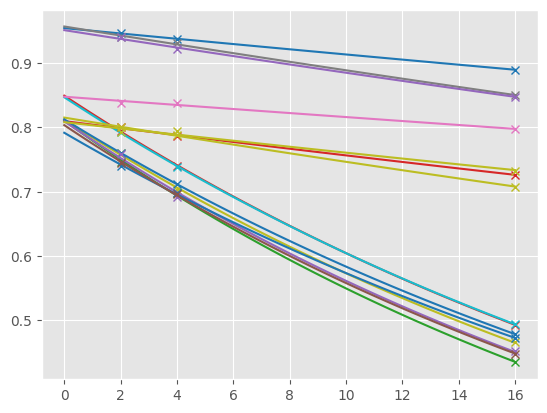

In [43]:
#The exponential decay shows that the channel was properly diagonalized
layer = experiment.analysis.get_layer_data(0)
layer.graph((0,),(1,),(0,1)) #input qubits and qubit links as tuples

<Axes: >

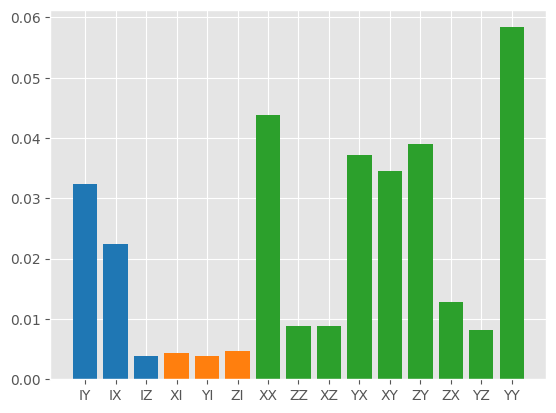

In [44]:
#plot the infidelities of different Paulis
layer.plot_infidelitites((0,),(1,),(0,1))

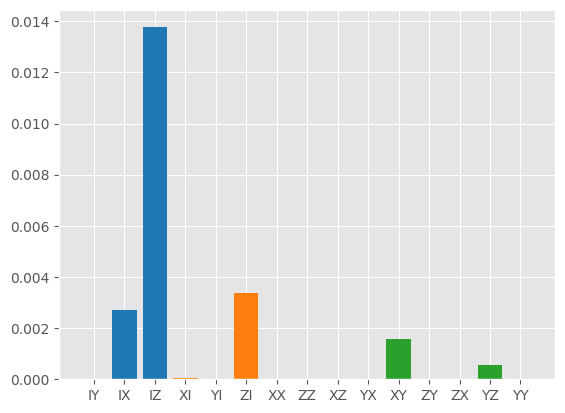

In [45]:
#plot the lambda_k for different terms
layer.plot_coeffs((0,),(1,),(1,0))

# PER
Now comes the portion where PER is implemented using the results of the tomography. The `experiment` class contains a method to set up a PER experiment with all of the parameters it needs. The circuits passed to the PER experiment are the ones that will be run with PER. This is supposed to reflect the fact that in an application such as simulation, usually one wants to find expectation values on many circuits at different times or with different parameters. 

In [46]:
empty_log()
perexp = experiment.create_per_experiment([qc])
perexp._per_circuits

### Generation of PER circuits
Per circuits are generated using the following method.
* For each layer of the circuit, first the single-qubit gates in the layer are composed into the circuit.
* Then, the Pauli twirl is composed into the layer
* The partial inverse of the noise at stength $\xi$ is sampled with the following method:
    * Let $\alpha =1$ be the ``scale factor" for the instance
    * For each layer $l$ in the circuit
        * For each term $P_k$ in the sparse model
            * Sample $I$ with probability $\omega_{lk}^{(\xi)}$ and $P_k$ otherwise
            * If $P_k$ was sampled, multiply $\alpha$ by $-1$
            * scale $\alpha$ by $\gamma_l^{(\xi)}$
        * Invert twirl through conjugation by Clifford gates, and compose into *next* layer
    * If $\xi < 1$, scale expectation value by $\alpha$

This provides a method for getting an estimator of the true expectation value without the influence of noise. At $\xi = 0$, the estimator is unbiased, and as $\xi \to \infty$, there is a tradeoff between precision and accuracy that results in an increasingly precise measurement with more and more noise-induced bias.

In [47]:
perexp.generate(
    expectations = ["IX", "XI"], #The expectation values to be measured on each of the circuits
    samples = 1000, #The number of joint samples from the twirling and PER partial inverse to take
    noise_strengths = [0,1,2] #The strengths of the noise to use
    )

TypeError: can only concatenate str (not "QiskitPauli") to str

In [ ]:
print_log_file("/home/fabrice/Dokumente/Masterarbeit/AutomatedPERTools/tests_and_figures/experiment.log")

2024-06-25 16:47:32,866 Generated layer profile with 1 layers:
2024-06-25 16:47:32,866 ["('cx', (Qubit(QuantumRegister(2, 'q'), 0), Qubit(QuantumRegister(2, 'q'), 1)))"]
2024-06-25 16:47:32,897 Created pauli bases
2024-06-25 16:47:32,897 ['XX', 'YX', 'ZX', 'XY', 'YY', 'ZY', 'XZ', 'YZ', 'ZZ']
2024-06-25 16:47:32,898 Testing here
2024-06-25 16:47:32,898 EdgeList[(0, 1), (1, 0)]
2024-06-25 16:47:32,901 NodeIndices[0, 1]
2024-06-25 16:47:32,901 Created model with the following terms:
2024-06-25 16:47:32,901 {'IX', 'YZ', 'XI', 'XX', 'YI', 'XY', 'ZI', 'YX', 'YY', 'IY', 'ZY', 'IZ', 'ZZ', 'XZ', 'ZX'}
2024-06-25 16:47:32,912 {IX: XX, YZ: YI, XI: XI, XX: IX, YI: YZ, XY: IY, ZI: ZZ, YX: ZY, YY: ZX, IY: XY, ZY: YX, IZ: IZ, ZZ: ZI, XZ: XZ, ZX: YY}
2024-06-25 16:47:32,951 Chose single bases:
2024-06-25 16:47:32,952 ['IX', 'ZY', 'YI', 'YY', 'XY', 'ZI']
2024-06-25 16:48:45,251 Created experiment consisting of 2652 instances
2024-06-25 16:49:21,052 Running analysis...
2024-06-25 16:49:38,661 Fit noise 

The program implements an algorithm to determine the most efficient way to measure the requested expectation values in as few shots as possible by making as many simultaneous measurements as possible. For instance, the basis of measurement chosen above was

In [ ]:
perexp.meas_bases

[XX]

Example of such a PER instance:

In [ ]:
#viewing one generated PER instance:
noise_strength = 0
inst = list([inst for inst in perexp._per_runs[0].instances if inst.noise_strength == noise_strength])[0]
print("Readout twirl:", inst._rostring)
inst._circ.qc.draw()

Readout twirl: IX


global phase: π
               ┌─────────┐ ┌────┐┌──────────┐      ░ ┌───┐┌──────────┐      ░ »
      q_0 -> 0 ┤ Rz(π/2) ├─┤ √X ├┤ Rz(3π/4) ├──■───░─┤ X ├┤ Rz(3π/4) ├──■───░─»
               ├─────────┴┐├────┤├─────────┬┘┌─┴─┐ ░ ├───┤└──────────┘┌─┴─┐ ░ »
      q_1 -> 1 ┤ Rz(-π/2) ├┤ √X ├┤ Rz(π/2) ├─┤ X ├─░─┤ X ├────────────┤ X ├─░─»
               └──────────┘└────┘└─────────┘ └───┘ ░ └───┘            └───┘ ░ »
ancilla_0 -> 2 ───────────────────────────────────────────────────────────────»
                                                                              »
ancilla_1 -> 3 ───────────────────────────────────────────────────────────────»
                                                                              »
ancilla_2 -> 4 ───────────────────────────────────────────────────────────────»
                                                                              »
       meas: 2/═══════════════════════════════════════════════════════════════»
                                                                              »
«                 ┌───┐   ┌───────────┐      ░ ┌─────────┐      ░ ┌─────────┐»
«      q_0 -> 0 ──┤ X ├───┤ Rz(-3π/4) ├──■───░─┤ Rz(π/4) ├──■───░─┤ Rz(π/2) ├»
«               ┌─┴───┴──┐└───┬───┬───┘┌─┴─┐ ░ └┬────────┤┌─┴─┐ ░ ├─────────┤»
«      q_1 -> 1 ┤ Rz(-π) ├────┤ X ├────┤ X ├─░──┤ Rz(-π) ├┤ X ├─░─┤ Rz(π/2) ├»
«               └────────┘    └───┘    └───┘ ░  └────────┘└───┘ ░ └─────────┘»
«ancilla_0 -> 2 ─────────────────────────────────────────────────────────────»
«                                                                            »
«ancilla_1 -> 3 ─────────────────────────────────────────────────────────────»
«                                                                            »
«ancilla_2 -> 4 ─────────────────────────────────────────────────────────────»
«                                                                            »
«       meas: 2/═════════════════════════════════════════════════════════════»
«                                                                            »
«               ┌────┐┌─────────┐ ░ ┌─┐   
«      q_0 -> 0 ┤ √X ├┤ Rz(π/2) ├─░─┤M├───
«               ├────┤├─────────┤ ░ └╥┘┌─┐
«      q_1 -> 1 ┤ √X ├┤ Rz(π/2) ├─░──╫─┤M├
«               └────┘└─────────┘ ░  ║ └╥┘
«ancilla_0 -> 2 ─────────────────────╫──╫─
«                                    ║  ║ 
«ancilla_1 -> 3 ─────────────────────╫──╫─
«                                    ║  ║ 
«ancilla_2 -> 4 ─────────────────────╫──╫─
«                                    ║  ║ 
«       meas: 2/═════════════════════╩══╩═
«                                    0  1

## Running per
PER can be run using the same executor used for the tomography experiment:

In [ ]:
perexp.run(executor)

## PER Results
The results can be obtained as a list corresponding to the input circuits. The results for each circuit are obtained by computing the estimator as described above.

In [ ]:
noise_strength = 0
insts = [inst for inst in perexp._per_runs[0].instances if inst.noise_strength == 0]
expectations = [inst.get_adjusted_expectation(QiskitPauli("IX")) for inst in insts]
# print(expectations)

The PEC value can be obtained by simply averaging the results above, and dividing by the SPAM coefficient for the measurement basis $IX$. The ideal value is $-1$. The readout mitigation scheme currently implemented implicitly treats readout errors as uncorrelated by making the assumption that the readout error for a pauli $P_a$ is the product of the readout error for each single-weight Pauli it is composed of. For instance, the SPAM coefficient for $XX$ is estimated to be the product of the spam coefficients for $IX$ and $XI$. 

Future versions of this package will implement readout mitigation that takes correlation in readout errors into account.

In [ ]:
print("PEC value:", np.mean(expectations)/noisedataframe.spam[QiskitPauli("IX")])
print("estimator deviation:", np.std(expectations))

PEC value: -1.016791844582509
estimator deviation: 0.18388867462359174


In [ ]:
circuit_results = perexp.analyze() #analyze the circuits to carry the above process out for each circuit, depth, and expectation value,
#and apply vZNE

In [ ]:
perexp.get_overhead(0,0) #get the overhead of circuit 0 at \xi = 0

1.192485106856289

## Results:
The results of a specific expectation value on the desired circuit can be obtained using the `get_result` method. Similar to the tomography, the package provides some tools for visualizing the PER data. Below, the exponential fit used for inference is shown against the convergence of the expectation value. If everything went right, the first plot should converge to -1, and the second should converge to +1.

<Axes: >

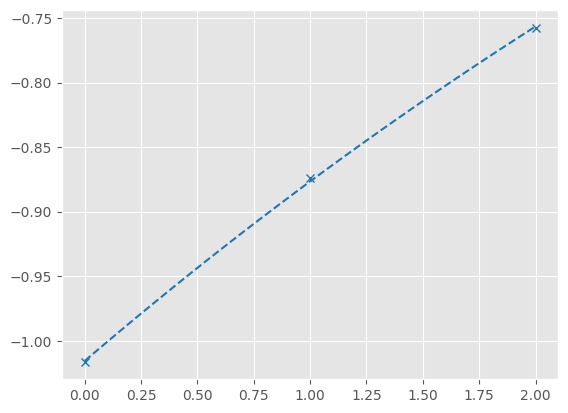

In [ ]:
circuit_results[0].get_result("IX").plot()

<Axes: >

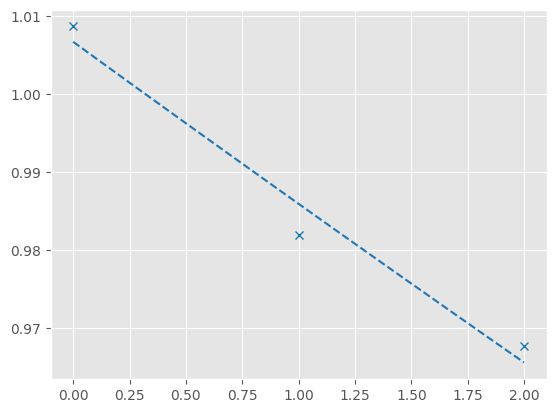

In [ ]:

circuit_results[0].get_result("XI").plot()